
# CGK-KUL

## Data Preparation

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')
from tabulate import tabulate

In [3]:
df_cgk_kul = pd.read_excel('/content/cgk_kul.xlsx', sheet_name=0, parse_dates=['Tanggal'])

In [4]:
df_cgk_kul.head()

,Tanggal,Harga
0,2022-03-30,4341000.0
1,2022-03-31,4341000.0
2,2022-04-01,4341000.0
3,2022-04-02,4341000.0
4,2022-04-03,4341000.0


In [5]:
df_cgk_kul.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Tanggal  231 non-null    datetime64[ns]
 1   Harga    231 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.7 KB


In [6]:
df_cgk_kul.set_index('Tanggal', inplace=True)
df_cgk_kul.tail(100)

,Harga
Tanggal,
2022-08-08,1033400.0
2022-08-09,1103792.0
2022-08-10,1199000.0
2022-08-11,1190400.0
2022-08-12,1190400.0
...,...
2022-11-11,1726045.0
2022-11-12,1637622.0
2022-11-13,1637622.0


## EDA

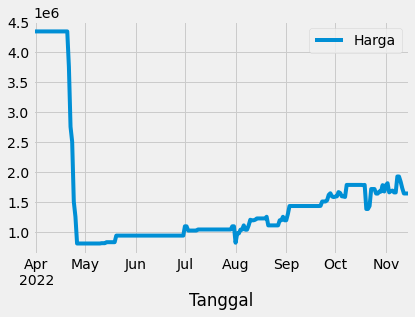

In [ ]:
df_cgk_kul.plot(kind='line')
plt.show()

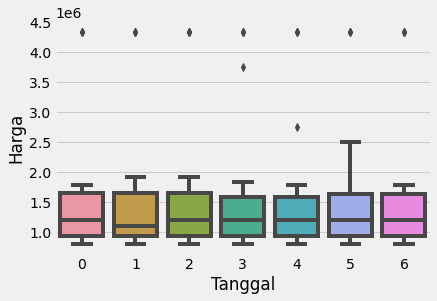

In [ ]:
sns.boxplot(x=df_cgk_kul.index.dayofweek, y=df_cgk_kul['Harga'])
plt.show()

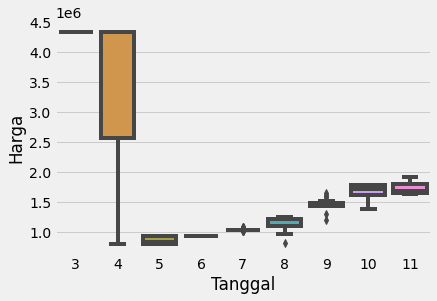

In [ ]:
sns.boxplot(x=df_cgk_kul.index.month, y=df_cgk_kul['Harga'])
plt.show()

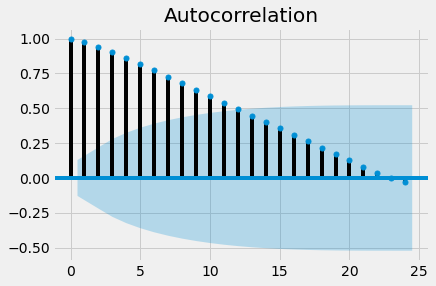

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import acf

plot_acf(df_cgk_kul['Harga'])
plt.show()

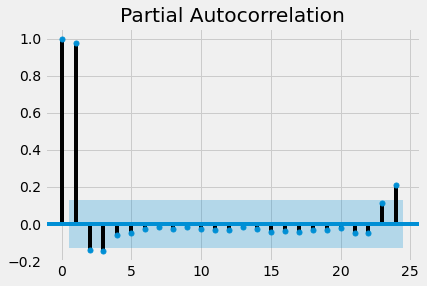

In [ ]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(df_cgk_kul['Harga'], method='ywm')
plt.show()

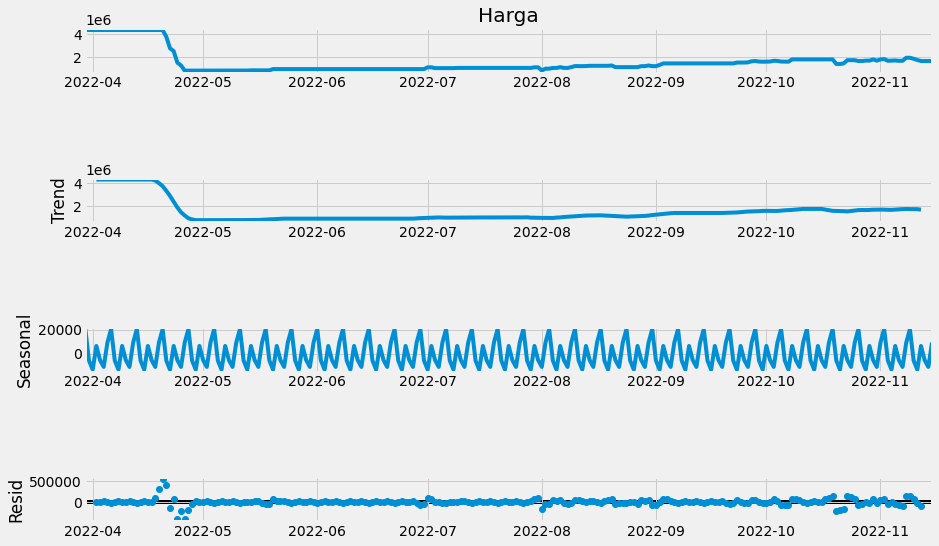

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_cgk_kul['Harga'])
fig = result.plot()
fig.set_size_inches((16, 9))
plt.show()

ide: ambil semua lag yg autocorr nya diluar biru, buatnya bukan lag2=lag2 aja, tapi lag2= lag1,lag2 dst untuk lag lainnya. Ini lebih make sense daripada ambil satu lag aja tiap nyoba.
link buat belajar parameter:
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/?
atau ga cari yg lain gpp, mgt guys maap aku ngaret terus <3

## Tuning Model yeah

In [7]:
#build lags
def create_features(df,n_lag,label=None):
    """
    Creates time series features from datetime index
    """
    df['lag'] = df['Harga'].shift(n_lag)
    
    X = df[['lag']]
    if label:
        y = df[label]
        return X, y
    return X

In [8]:
from datetime import timedelta, datetime
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
#tuning train test split
def cross_validation(data,n_lags,n_splits=10,n_iter=10):
  s= datetime(2022,3,30)  #hari pertama data diambil
  t = datetime(2022,8,8)  #100 hari terakhir
  days_until_depart=100
  rmse_split_mean=[]
  rmse_total_split=[]
  print('=== CROSS VALIDATE LAGS {} START ==='.format(n_lags))
  for i in range(0,days_until_depart,n_splits):
    split_date = t
    s_train = data.loc[s+timedelta(days=n_lags)<data.index].copy()
    train = s_train.loc[s_train.index <= split_date].copy()
    test = data.loc[data.index >= split_date].copy()
    X_train, y_train = create_features(train,n_lags,label='Harga')
    X_test, y_test = create_features(test,n_lags,label='Harga')
    split=100
    tscv = TimeSeriesSplit(n_splits=split)
    rmse=[]
    param=[]
    for j in range(n_iter):
      reg = xgb.XGBRegressor()
      reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=0)
      y_pred=reg.predict(X_test)
      rmse.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    rmse_total_split.append(rmse)
    rmse_split_mean.append(np.mean(rmse))
    t = t - timedelta(days=10)
  rmse_total_split = np.array( rmse_total_split)
  print('Lags {0} RMSE: {1}\n'.format(n_lags, rmse_split_mean))
  return rmse_total_split, rmse_split_mean

In [ ]:
rmse_lags5, rmse_lags5_mean = cross_validation(df_cgk_kul, n_lags=5)
rmse_lags4, rmse_lags4_mean = cross_validation(df_cgk_kul, n_lags=4)
rmse_lags3, rmse_lags3_mean = cross_validation(df_cgk_kul, n_lags=3)
rmse_lags2, rmse_lags2_mean = cross_validation(df_cgk_kul, n_lags=2)
rmse_lags1, rmse_lags1_mean = cross_validation(df_cgk_kul, n_lags=1)

=== CROSS VALIDATE LAGS 5 START ===
[11:29:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:29:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:lin

In [ ]:
print('Lags 5 RMSE Mean:', np.mean(rmse_lags5_mean))
print('Lags 4 RMSE Mean:', np.mean(rmse_lags4_mean))
print('Lags 3 RMSE Mean:', np.mean(rmse_lags3_mean))
print('Lags 2 RMSE Mean:', np.mean(rmse_lags2_mean))
print('Lags 1 RMSE Mean:', np.mean(rmse_lags1_mean))

Lags 5 RMSE Mean: 838663.812219267
Lags 4 RMSE Mean: 776112.9982647102
Lags 3 RMSE Mean: 744731.615544677
Lags 2 RMSE Mean: 697486.5405701955
Lags 1 RMSE Mean: 433919.16683262464


In [ ]:
rmse_lags1.mean(axis=1)

array([499345.75056657, 476215.37328207, 455137.69488124, 439320.48843804,
       438813.35060028, 424167.11903223, 410412.46962137, 398248.59613329,
       397996.3925671 , 399534.43320406])

## Tuning Lagi

Ambil lag= 1 dan test=80, karena mean RMSE nya paling rendah

In [ ]:
df_cgk_kul.tail(90)

,Harga
Tanggal,
2022-08-18,1221230.0
2022-08-19,1221230.0
2022-08-20,1249000.0
2022-08-21,1105400.0
2022-08-22,1105400.0
...,...
2022-11-11,1726045.0
2022-11-12,1637622.0
2022-11-13,1637622.0


In [9]:
s= datetime(2022,3,30)
t=datetime(2022,8,18)
split_date = t
s_train = df_cgk_kul.loc[s+timedelta(days=1)<df_cgk_kul.index].copy()
train = s_train.loc[s_train.index <= split_date].copy()
test = df_cgk_kul.loc[df_cgk_kul.index >= split_date].copy()
X_train, y_train = create_features(train,1,label='Harga')
X_test, y_test = create_features(test,1,label='Harga')

In [ ]:
y_test

Tanggal
2022-08-18    1221230.0
2022-08-19    1221230.0
2022-08-20    1249000.0
2022-08-21    1105400.0
2022-08-22    1105400.0
                ...    
2022-11-11    1726045.0
2022-11-12    1637622.0
2022-11-13    1637622.0
2022-11-14    1637622.0
2022-11-15    1637622.0
Name: Harga, Length: 90, dtype: float64

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=100)
rmse=[]
param_tun=[]
for i in range(10):
  params = {'max_depth': [3, 5, 6, 7, 8, 9, 10],
            'min_child_weight':[6, 5, 4, 3, 2],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 0.75, 1.0),            #Typical values: 0.5-1
           'colsample_bytree': np.arange(0.5, 0.75, 1.0),     #Typical values: 0.5-1
           'colsample_bylevel': np.arange(0.5, 0.75, 1.0),    #Typical values: 0.5-1
           'eta':[0.01, 0.015, 0.05, 0.075, 0.1, 0.15, 0.2],           #Typical final values to be used: 0.01-0.2  
           'lambda':[0.00001, 0.0001, 0.001, 0.01, 0.05],              #L2 regularization, (0,0.1)
           'gamma':[0.01, 0.015, 0.05, 0.075, 0.1, 0.15, 0.2],        #Typical final values to be used: 0.01-0.2 
           'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.05],              #L1 regularization, (0,0.1)
           'n_estimators': [100, 500, 1000]}
  xgbr = xgb.XGBRegressor(seed = 20)
  clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='neg_mean_squared_error',
                         n_iter=100,cv=tscv,
                         verbose=1)
  clf.fit(X_train,y_train)
  rmse.append((-clf.best_score_)**(1/2.0))
  param_tun.append(clf.best_params_)

Streaming output truncated to the last 5000 lines.
[13:01:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:01:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:01:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:01:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:01:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:01:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:01:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:01:11] WARNING: /workspace/src/objective/regression_obj.

In [ ]:
print('Nilai RMSE Maksimal=',np.max(rmse))
print('Nilai RMSE Minimal=',np.min(rmse))
print('Nilai Rata-rata RMSE=',np.mean(rmse))
print('Nilai Median RMSE=',np.median(rmse))
print('Parameter untuk RMSE Minimal:',param_tun[rmse.index(np.min(rmse))])

Nilai RMSE Maksimal= 53270.89779855069
Nilai RMSE Minimal= 52976.14659010127
Nilai Rata-rata RMSE= 53069.58744474433
Nilai Median RMSE= 53045.211105274015
Parameter untuk RMSE Minimal: {'subsample': 0.5, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.1, 'lambda': 0.001, 'gamma': 0.2, 'eta': 0.1, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'alpha': 0.0001}


## Prediction

'subsample': 0.5, 'n_estimators': 100, 'min_child_weight': 3, 'max_depth': 6, 'learning_rate': 0.1, 'lambda': 0.001, 'gamma': 0.2, 'eta': 0.1, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'alpha': 0.0001}

In [10]:
reg = xgb.XGBRegressor(subsample= 0.5,n_estimators=100,min_child_weight=3,max_depth=6, gamma=0.2,
                       learning_rate=0.01,colsample_bytree= 0.5,eta=0.1,
                       colsample_bylevel= 0.5,reg_alpha=0.0001, 
                       reg_lambda=0.001)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

[08:32:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bylevel=0.5, colsample_bytree=0.5, eta=0.1, gamma=0.2,
             learning_rate=0.01, max_depth=6, min_child_weight=3,
             reg_alpha=0.0001, reg_lambda=0.001, subsample=0.5)

In [11]:
test['Test_Prediksi'] = reg.predict(X_test)
all = pd.concat([test, train], sort=False)

In [12]:
y_test

Tanggal
2022-08-18    1221230.0
2022-08-19    1221230.0
2022-08-20    1249000.0
2022-08-21    1105400.0
2022-08-22    1105400.0
                ...    
2022-11-11    1726045.0
2022-11-12    1637622.0
2022-11-13    1637622.0
2022-11-14    1637622.0
2022-11-15    1637622.0
Name: Harga, Length: 90, dtype: float64

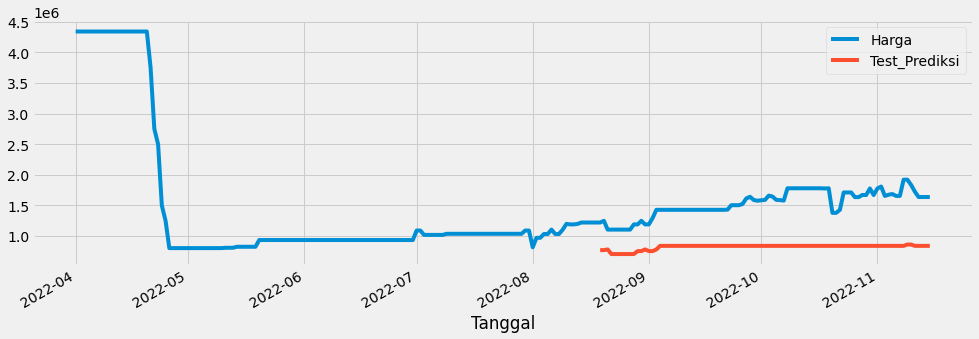

In [13]:
_ = all[['Harga','Test_Prediksi']].plot(figsize=(15, 5))

In [14]:
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

In [15]:
X_test

,lag
Tanggal,
2022-08-18,NaN
2022-08-19,1221230.0
2022-08-20,1221230.0
2022-08-21,1249000.0
2022-08-22,1105400.0
...,...
2022-11-11,1835868.0
2022-11-12,1726045.0
2022-11-13,1637622.0


In [16]:
df_cgk_kul2 = df_cgk_kul.copy()
df_cgk_kul2['Prediksi'] = 0

df_cgk_kul2.tail(100)

,Harga,Prediksi
Tanggal,,
2022-08-08,1033400.0,0
2022-08-09,1103792.0,0
2022-08-10,1199000.0,0
2022-08-11,1190400.0,0
2022-08-12,1190400.0,0
...,...,...
2022-11-11,1726045.0,0
2022-11-12,1637622.0,0
2022-11-13,1637622.0,0


In [17]:
y_test_pred.shape

(90,)

In [18]:
df_cgk_kul2.iloc[:1, 1] = np.nan
df_cgk_kul2.iloc[1:-90, 1] = y_train_pred
df_cgk_kul2

,Harga,Prediksi
Tanggal,,
2022-03-30,4341000.0,NaN
2022-03-31,4341000.0,2708390.75
2022-04-01,4341000.0,2722638.00
2022-04-02,4341000.0,2722638.00
2022-04-03,4341000.0,2722638.00
...,...,...
2022-11-11,1726045.0,0.00
2022-11-12,1637622.0,0.00
2022-11-13,1637622.0,0.00


In [19]:
df_cgk_kul2.iloc[-90:, 1] = y_test_pred
df_cgk_kul2

,Harga,Prediksi
Tanggal,,
2022-03-30,4341000.0,NaN
2022-03-31,4341000.0,2.708391e+06
2022-04-01,4341000.0,2.722638e+06
2022-04-02,4341000.0,2.722638e+06
2022-04-03,4341000.0,2.722638e+06
...,...,...
2022-11-11,1726045.0,8.397954e+05
2022-11-12,1637622.0,8.397954e+05
2022-11-13,1637622.0,8.397954e+05


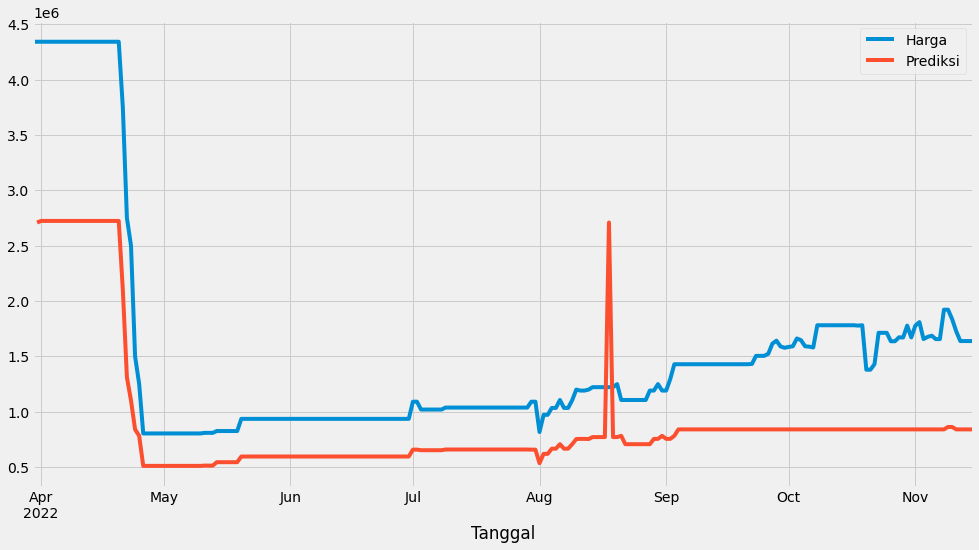

In [20]:
fig, ax = plt.subplots(figsize=(15,8))
df_cgk_kul2.plot(kind='line', ax=ax)
plt.show()

## Forecast

In [21]:
X_test

,lag
Tanggal,
2022-08-18,NaN
2022-08-19,1221230.0
2022-08-20,1221230.0
2022-08-21,1249000.0
2022-08-22,1105400.0
...,...
2022-11-11,1835868.0
2022-11-12,1726045.0
2022-11-13,1637622.0


In [22]:
from datetime import timedelta, datetime
def forecast(data, nlags, days_until_depart):
  t = datetime(2022, 11, 15)
  time_list = [t]
  hasil_forecast=[1637622] #pokonya ini ambil data X_test indeksnya [-n_lags:], bebas lo ambilnya gimanss
  days_until_depart=44     #hari sblom brangkat, kalo lstm 1 hari sebelum berangkat

  for i in range(days_until_depart):
    forecast_={'lag':hasil_forecast}
    apaiya_df = pd.DataFrame(forecast_, index=time_list)
    fr=reg.predict(apaiya_df)
    list(fr)
    hasil_forecast.append(fr[i])
    time = t + timedelta(days=1)
    t = time
    time_list.append(time)
  apaiya_df.rename(columns={'lag': 'forecast'})
  return apaiya_df

In [23]:
apaiya_df=forecast(X_test, 1, 44)

In [24]:
apaiya_df

,lag
2022-11-15,1.637622e+06
2022-11-16,8.397954e+05
2022-11-17,5.436169e+05
2022-11-18,5.101441e+05
2022-11-19,5.101441e+05
2022-11-20,5.101441e+05
2022-11-21,5.101441e+05
2022-11-22,5.101441e+05
2022-11-23,5.101441e+05
2022-11-24,5.101441e+05


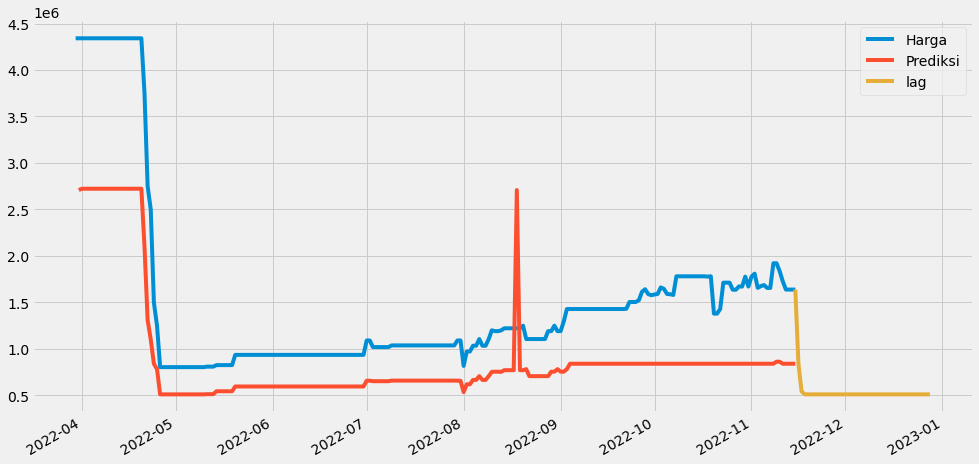

In [25]:
#Membuat plot 

from datetime import timedelta, datetime
df_cgk_kul3 = df_cgk_kul2.append(apaiya_df)
fig, ax = plt.subplots(figsize=(15,8))
df_cgk_kul3.plot(kind='line', ax=ax)
plt.show()

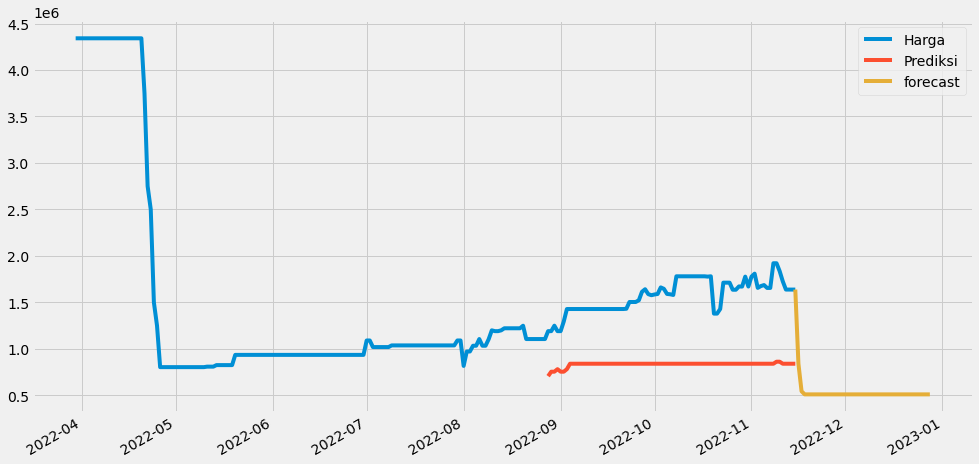

In [29]:
#Membuat plot 

from datetime import timedelta, datetime
df_cgk_kul4 = df_cgk_kul3
df_cgk_kul4.rename(columns = {'lag':'forecast'}, inplace = True)
df_cgk_kul4.iloc[1:-124, 1] = np.nan
fig, ax = plt.subplots(figsize=(15,8))
df_cgk_kul4.plot(kind='line', ax=ax)
plt.show()

# Koefisien Variansi

In [ ]:
df_cgk_kul.describe()

,Harga
count,2.310000e+02
mean,1.534949e+06
std,9.858479e+05
min,8.031990e+05
25%,9.350000e+05
50%,1.190400e+06
75%,1.639420e+06
max,4.341000e+06


In [ ]:
print('Koefisien Variansi CGK-KUL:',(np.sqrt(mean_squared_error(y_test,y_test_pred))/1.534949e+06)*100,'%')

Koefisien Variansi CGK-KUL: 48.61408275457806 %


In [ ]:
a=np.sqrt(mean_squared_error(y_test,y_test_pred))
a

746201.3771005684